In [1]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

In [6]:
label_dict = ['T-shirt/top', 'Trouser', 'Pullover', 
              'Dress', 'Coat', 'Sandal', 'Shirt', 
              'Sneaker', 'Bag', 'Ankle boot']

In [3]:
train_X = train_images.reshape((60000, 28, 28, 1))
test_X = test_images.reshape((10000, 28, 28, 1))

train_X = tf.cast(train_X, tf.float32)
test_X = tf.cast(test_X, tf.float32)


train_y = tf.one_hot(train_labels, 10)
test_y = tf.one_hot(test_labels, 10)

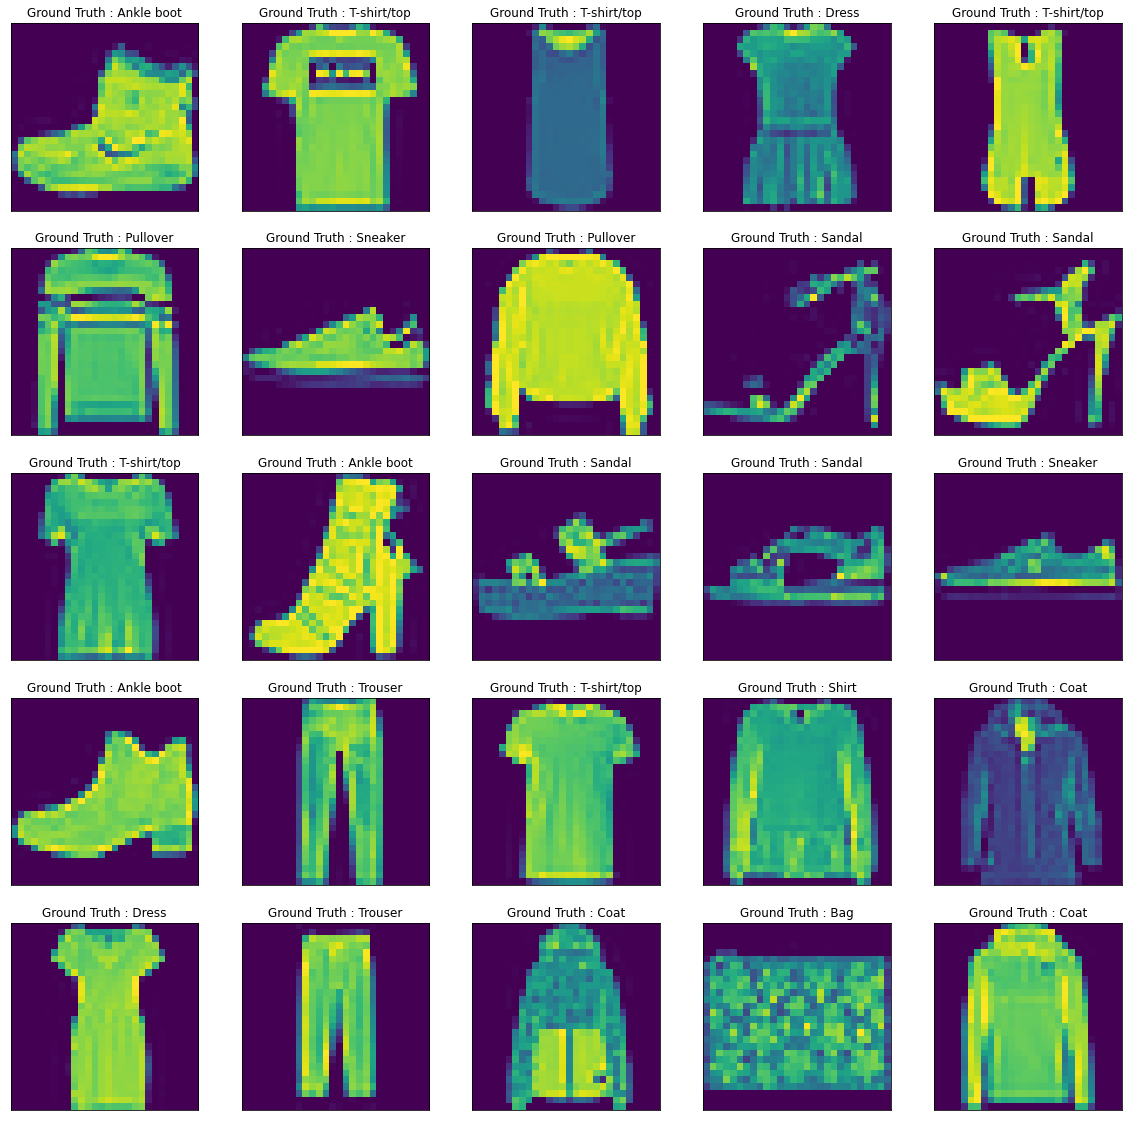

In [8]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_X[i])
    plt.title("Ground Truth : {}".format(label_dict[train_labels[i]]))

plt.show()

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [10]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [11]:
model.compile(optimizer='SGD',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

history = model.fit(train_X, train_y, epochs=10, batch_size=20)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 123s 2ms/sample - loss: 6.2584 - accuracy: 0.6035
Epoch 2/10
60000/60000 [==============================] - 123s 2ms/sample - loss: 0.5777 - accuracy: 0.7912
Epoch 3/10
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.5228 - accuracy: 0.8063
Epoch 4/10
60000/60000 [==============================] - 123s 2ms/sample - loss: 0.4942 - accuracy: 0.8168
Epoch 5/10
60000/60000 [==============================] - 123s 2ms/sample - loss: 0.4712 - accuracy: 0.8226
Epoch 6/10
60000/60000 [==============================] - 123s 2ms/sample - loss: 0.4582 - accuracy: 0.8274
Epoch 7/10
60000/60000 [==============================] - 122s 2ms/sample - loss: 0.4432 - accuracy: 0.8327
Epoch 8/10
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.4325 - accuracy: 0.8360
Epoch 9/10
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.4250 - accuracy: 0.8402
Epoch

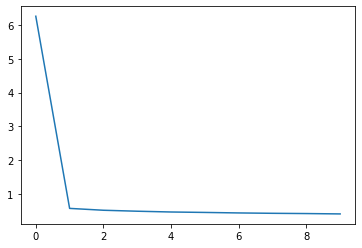

In [12]:
plt.plot(history.history['loss'])

In [13]:
test_X.dtype

tf.float32

In [14]:
train_X.dtype

tf.float32

In [15]:
train_X = tf.cast(train_X, tf.float32)
pred_train_y = model.predict(x=train_X)

In [19]:
pred_train_label = []
for i in range(0, len(pred_train_y)):
    pred_train_label.append(tf.keras.backend.eval(tf.argmax(pred_train_y[i])))

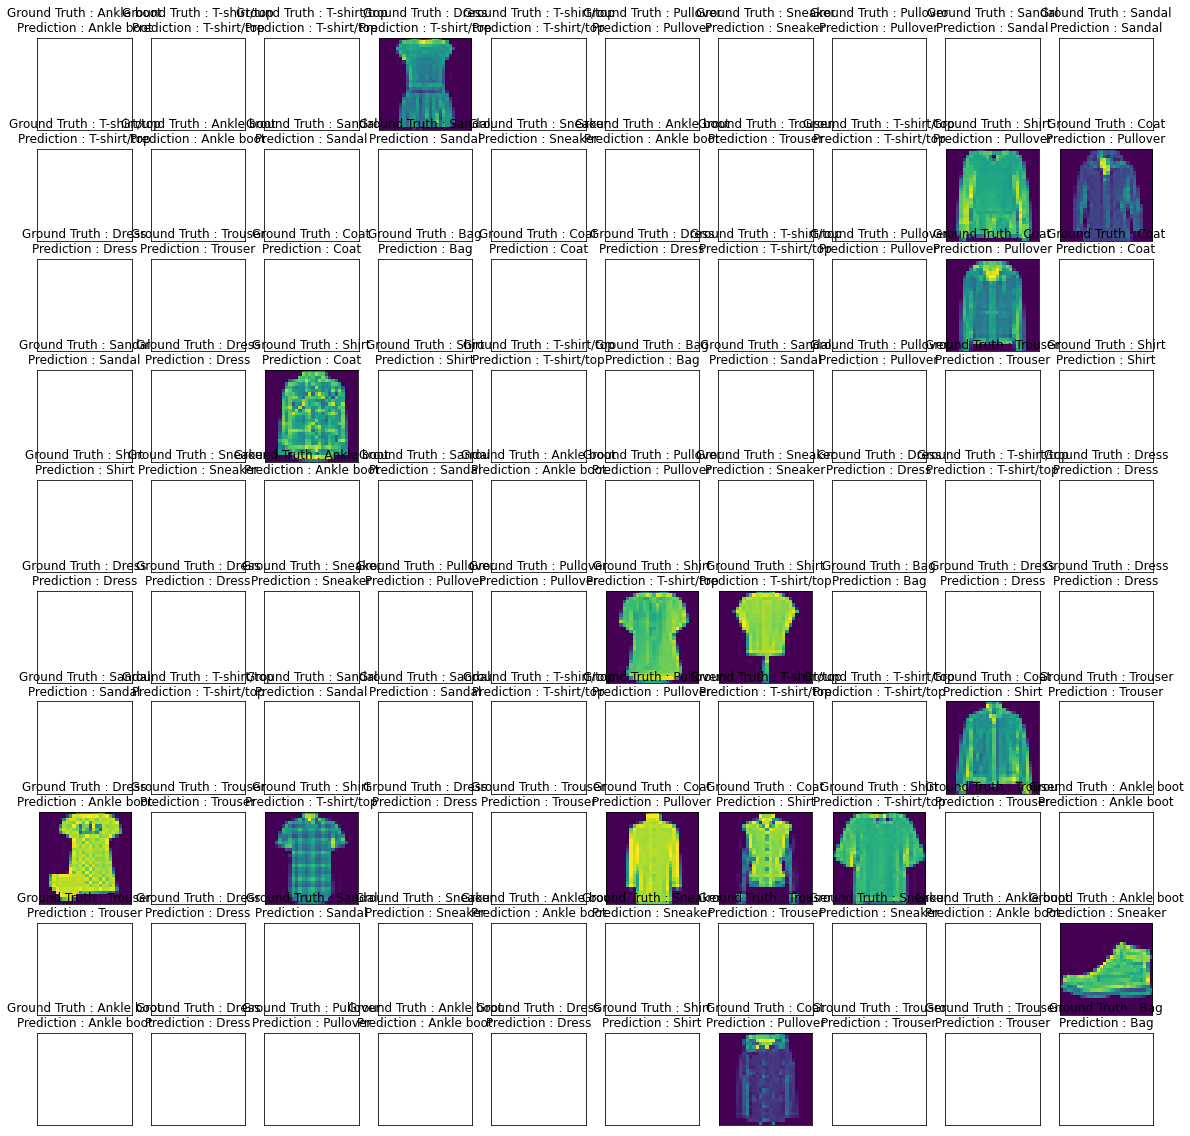

In [31]:
plt.figure(figsize=(20,20))

for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if train_labels[i] != pred_train_label[i]:
        plt.imshow(train_images[i])
    plt.title("Ground Truth : {}".format(label_dict[train_labels[i]]) + '\n' +
              "Prediction : {}".format(label_dict[pred_train_label[i]]))

plt.show()

In [ ]:
train_images[train_labels != pred_train_label]

In [ ]:
'''
TODO:
- Implement training
- Tune the model
- Transform training data for performance
- Show CNN filters at each level
- Validation / testing split
'''